<a href="https://colab.research.google.com/github/himanshunaidu/cnn_analysis/blob/master/CNN_occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import math
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPool2D, LeakyReLU, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
cnn_saver = 'gdrive/My Drive/Colab Notebooks/CNN_Analysis/Model'
cnn_loader = 'gdrive/My Drive/Colab Notebooks/CNN_Analysis/Model'

# Get the Data

In [ ]:
cifar10 = tf.keras.datasets.cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
# print(X_train.shape, y_train.shape)
x_shape = X_train[0].shape
print(x_shape)

(32, 32, 3)


In [ ]:
y_train, y_test = y_train.flatten(), y_test.flatten()

# Create the Network

In [ ]:
#For padding
def plus_one_pad(tensor, mode):
    return tf.pad(tensor, [[0, 0], [1, 1], [1, 1], [0, 0]], mode)

#For initialization
def initializer(length):
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0) #1/math.sqrt(length/2))

In [ ]:
alpha = 0.15

#Network
def createNetwork():
    i = Input(shape=(x_shape[0], x_shape[1], x_shape[2]))
    x = Conv2D(32, (9, 9), padding='same', activation=LeakyReLU(alpha=alpha), kernel_initializer=initializer(3*3))(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation=LeakyReLU(alpha=alpha), kernel_initializer=initializer(3*3))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)

    # print(x)
    x = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=alpha), kernel_initializer=initializer(3*3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=alpha), kernel_initializer=initializer(3*3))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)

    # print(x)
    x = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=alpha), kernel_initializer=initializer(3*3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=alpha), kernel_initializer=initializer(3*3))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)

    # print(x)
    x = Flatten()(x)
    # x = Dense(2048, activation=LeakyReLU(alpha=0.3))(x) #2304 = 12x12x64/4
    x = Dropout(0.3)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.3))(x)
    x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax')(x)

    # print(x)
    model = Model(i, x)
    return model

In [ ]:
def custom_loss(y_true, y_pred):
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    loss = scce(y_true, y_pred)

    for index in range(len(y_true)):
        if y_true[index][0]==3:
            loss_1 = abs(1-y_pred[index][3])
            loss = loss + loss_1
    return loss

In [ ]:
model = createNetwork()
model.compile(optimizer='adam',loss=custom_loss,metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        7808      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        1849

In [ ]:
model.load_weights(cnn_loader)

In [ ]:
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50) 

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_saver, save_weights_only=True, verbose=1)
datagen = ImageDataGenerator(width_shift_range=0.2,  height_shift_range=0.2, horizontal_flip=True, fill_mode='constant')
batch_size = 32
steps_per_epoch = X_train.shape[0]//batch_size
traingen = datagen.flow(X_train, y_train, batch_size)
r = model.fit_generator(traingen, steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test, y_test), callbacks=[cp_callback])

In [ ]:
# r = model.fit_generator(traingen, steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test, y_test), callbacks=[cp_callback])

In [ ]:
layer = model.layers[1]
weights = np.array(layer.get_weights()[0])
print(len(model.layers))

21


In [ ]:
# print(weights.shape)
for i in range(len(model.layers)):
  layer = model.layers[i]
  if len(layer.get_weights())>0:
    print(np.array(layer.get_weights()[0]).shape)

(9, 9, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(2048, 1024)
(1024, 10)


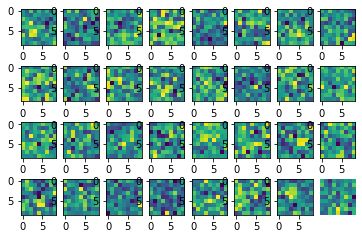

In [ ]:
from sklearn import preprocessing
fig, axs = plt.subplots(4, 8)
# weights.shape[3]
plt.axis('off')
rows = 4
cols = 8
row = 0
col = 0
for i in range(weights.shape[3]):
  v = weights[:,:,0,i]
  v_min = v.min(axis=(0, 1), keepdims=True)
  v_max = v.max(axis=(0, 1), keepdims=True)
  v = (v - v_min)/(v_max - v_min)
  axs[row, col].imshow(v)
  row = row + (col+1)//cols
  col = (col+1)%cols
plt.show()

In [ ]:
# plt.imshow(X_train[0])
pred = model.predict(x=X_train[0:1]).argmax()
print(pred, y_train[0])

6 6


In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[0], image.shape[1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = np.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            # input_image = image.clone().detach()
            input_image = np.copy(image)
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            # output = model(input_image)
            # output = nn.functional.softmax(output, dim=1)
            # prob = output.tolist()[0][label]
            prob = model.predict(x=np.array([input_image]))[0,label]
            
            #setting the heatmap location to probability value
            # print(prob)
            heatmap[h, w] = prob 

    return heatmap

In [ ]:
def checkHeatmap(image, label, occ_size, occ_stride):
  heatmap = occlusion(model, image, label, occ_size, occ_stride)
  print(heatmap.shape)
  imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
  figure = imgplot.get_figure()

In [ ]:
print(model.predict(x=np.array([X_train[4]])).argmax())
print(y_train[4])

1
1


(23, 23)


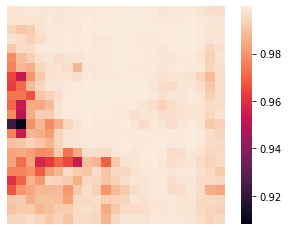

In [ ]:
checkHeatmap(X_train[1], y_train[1], 9, 1)

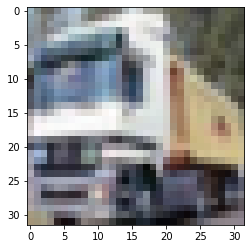

In [ ]:
plt.imshow(X_train[1])